# Assignment Setup

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
# Define the directory where the CSV files are located.
directory = '/workspaces/07-visualization-irisk2050/ddf--datapoints--population--by--country--age--gender--year'  # Adjust this path as needed

# Initialize an empty dictionary to store the dataframes.
data = {}

# Print the list of files in the directory.
files = os.listdir(directory)
### print(f"Found {len(files)} files in the directory.")

# Loop through the files in the directory.
for filename in files:
    ### print(f"Processing file: {filename}")
    
    if filename.endswith(".csv") and 'ddf--datapoints--population--by--country' in filename:
        try:
            # Extract the country abbreviation from the filename
            country_abbrev = filename.split('--')[4][-3:]
            ### print(country_abbrev)
            
            # Construct the full file path
            filepath = os.path.join(directory, filename)
            
            # Read the CSV file into a dataframe
            df = pd.read_csv(filepath)
            
            # Add a new column for the country abbreviation
            df['country'] = country_abbrev
            
            # Store the dataframe in the dictionary, using country abbreviation as key
            data[country_abbrev] = df
        except Exception as e:
            print(f"Error processing file {filename}: {e}")

# Check how many dataframes were loaded.
### print(f"Loaded dataframes for {len(data)} countries.")

# Combine all dataframes into one.
combined_df = pd.concat(data.values(), ignore_index=True)

combined_df.head()

,country,age,gender,year,population
0,syr,0,1,1950,74408
1,syr,0,1,1951,77115
2,syr,0,1,1952,79953
3,syr,0,1,1953,82811
4,syr,0,1,1954,85767


# Part 1: Matplotlib

## 1. Create a line plot comparing total population over time:
   - Choose 5 countries
   - Calculate the total population by country for each year
   - Create a line plot showing population trends
   - Include a legend identifying each country
   - Add appropriate axis labels and title
   - Use different line styles or colors to distinguish the countries

In [4]:
### print(sorted(combined_df['country'].unique()))
# selected 5 countries: 'esp', 'fin', 'fra', 'sgp', 'usa'

# Calculate the total population by country for each year
filtered5 = combined_df[combined_df['country'].isin(['esp', 'fra', 'fin', 'sgp', 'usa'])]
# filtered5['country'].unique()

yearly_total = filtered5.groupby(['country', 'year'])['population'].sum().reset_index()
yearly_total

,country,year,population
0,esp,1950,28077051
1,esp,1951,28214867
2,esp,1952,28406045
3,esp,1953,28632702
4,esp,1954,28857829
...,...,...,...
750,usa,2096,418800087
751,usa,2097,419461007
752,usa,2098,420095822
753,usa,2099,420702881


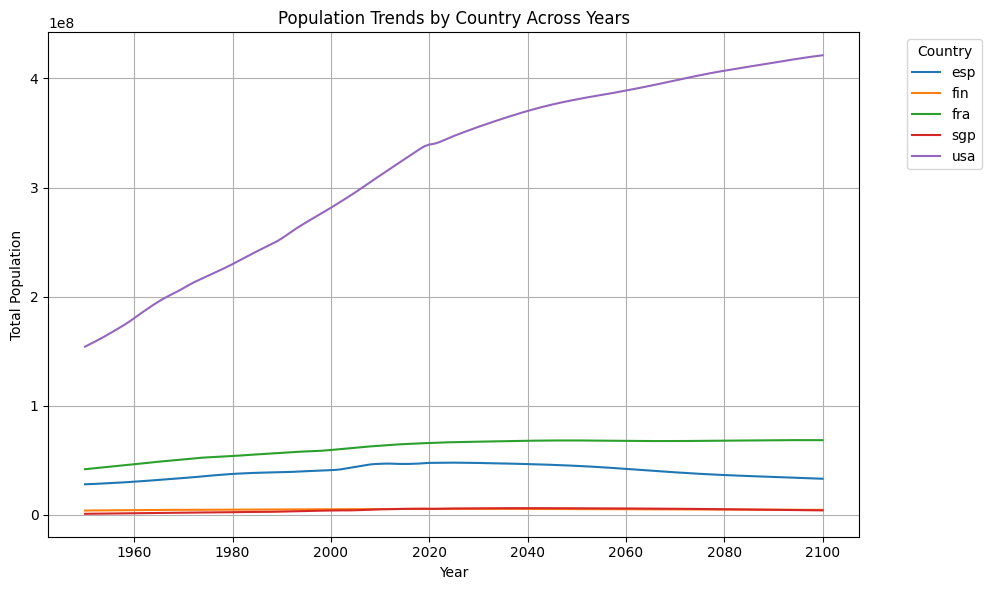

In [5]:
# Create a figure and axis object.
plt.figure(figsize=(10, 6))

# Plot population trends for each country.
for c in yearly_total['country'].unique():
    # Filter the data for the current country
    country_data = yearly_total[yearly_total['country'] == c]
    
    # Plot the data (using different styles/colors automatically)
    plt.plot(country_data['year'], country_data['population'], label = c)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Total Population')
plt.title('Population Trends by Country Across Years')

# Add a legend to identify each country
plt.legend(title = 'Country', bbox_to_anchor = (1.05, 1), loc = 'upper left')

# Display the plot
plt.tight_layout()  # Adjust layout so that everything fits
plt.grid() # Add grid lines for readability
plt.show()

## 2. Investigate demographic shifts using a stacked bar chart:
   - Compare age distributions (0-14, 15-30, 31-45, 46-65, 66+) between 1950, 1985, and 2020
   - Create a stacked bar chart showing these changes
   - Calculate and display the percentage for each age group
   - Add text annotations showing key percentages
   - Include clear labels and a legend

In [ ]:
### filtered5['age'].unique()
### filtered5.dtypes
### max(filtered5['age'])

/tmp/ipykernel_59070/884413164.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered5.loc[:, 'age_group'] = filtered5['age'].apply(categorize_age)


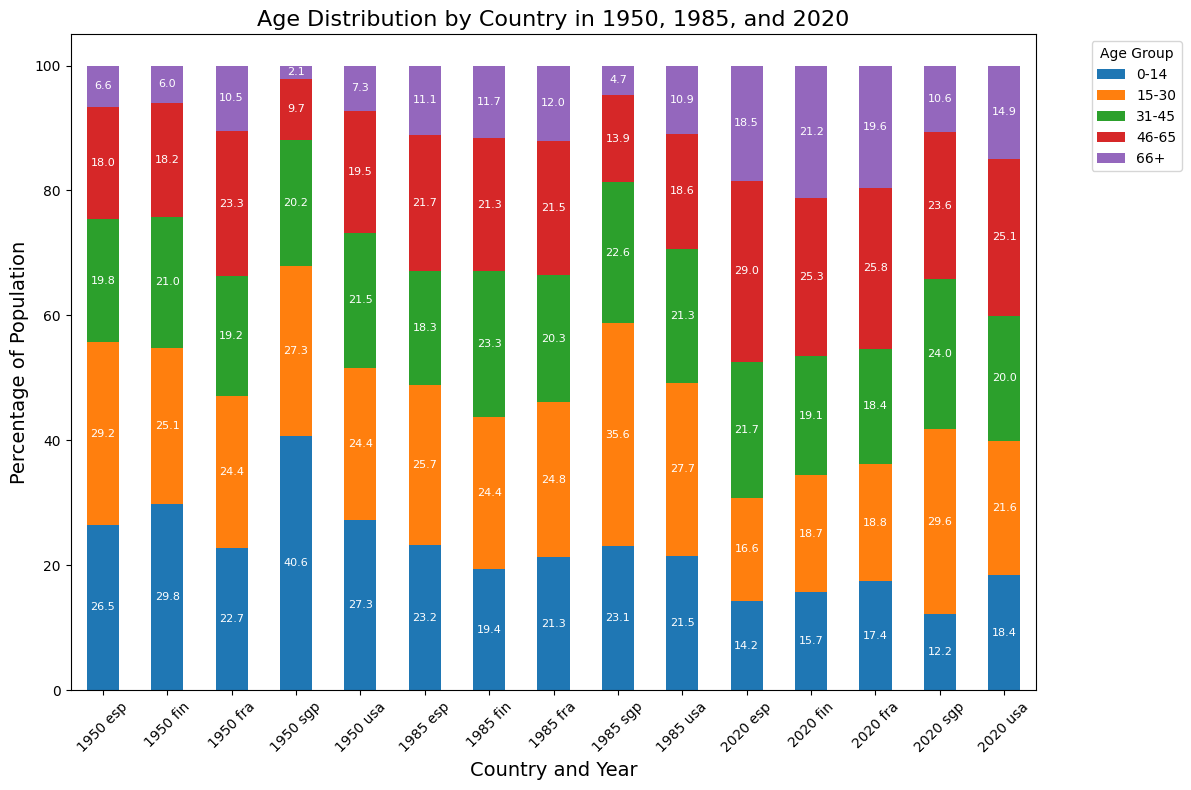

In [6]:
def categorize_age(age):
    if age <= 14:
        return '0-14'
    elif age <= 30:
        return '15-30'
    elif age <= 45:
        return '31-45'
    elif age <= 65:
        return '46-65'
    else:
        return '66+'

# Apply age categorization with .loc to avoid SettingWithCopyWarning
filtered5.loc[:, 'age_group'] = filtered5['age'].apply(categorize_age)

# Filter for the years of interest
years_of_interest = [1950, 1985, 2020]
filtered_years = filtered5[filtered5['year'].isin(years_of_interest)]

# Group by year and country, summing populations by age group
age_distribution = filtered_years.groupby(['year', 'country', 'age_group'])['population'].sum().unstack(fill_value=0)

# Calculate percentages for each age group
age_distribution_percentage = age_distribution.div(age_distribution.sum(axis=1), axis=0) * 100

# Reorder the index to ensure years are grouped together with countries in the specified order
countries_order = ['esp', 'fin', 'fra', 'sgp', 'usa']  # Ensure this list has the countries in the desired order
age_distribution_percentage = age_distribution_percentage.reindex(
    pd.MultiIndex.from_product([years_of_interest, countries_order], names=['year', 'country']),
    fill_value=0
)

# Create a stacked bar chart
ax = age_distribution_percentage.plot(kind='bar', stacked=True, figsize=(12, 8))

# Add labels and title
plt.title('Age Distribution by Country in 1950, 1985, and 2020', fontsize=16)
plt.xlabel('Country and Year', fontsize=14)
plt.ylabel('Percentage of Population', fontsize=14)

# Create custom x-tick labels
xticks_labels = [f"{year} {country}" for year in years_of_interest for country in countries_order]
plt.xticks(ticks=range(len(xticks_labels)), labels=xticks_labels, rotation=45)

# Add percentage annotations rounded to one decimal place
for i, (year, country) in enumerate(age_distribution_percentage.index):
    row = age_distribution_percentage.loc[(year, country)]  # Get the row as a Series
    y_values = row.cumsum()  # Cumulative sum for positioning
    for j in range(len(row)):
        value = row.iloc[j]  # Use iloc to access by position
        # Calculate the position for annotation
        y_value = y_values.iloc[j] - value / 2
        # Round the value for annotation
        percentage_text = f"{value:.1f}"
        plt.text(i, y_value, percentage_text, ha='center', va='center', fontsize=8, color = 'white')

# Move the legend outside the plot to the upper right
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()  # Adjust layout to fit everything
plt.show()


# Part 2: Seaborn

## 1. Create a heatmap showing the population distribution across age groups (0-14, 15-30, 31-45, 46-65, 66+) and country for 5 countries of your choice in a specific year.
   - Use seaborn's heatmap function
   - Add clear annotations and labels
   - Write a brief explanation of what the heatmap reveals about the population structure

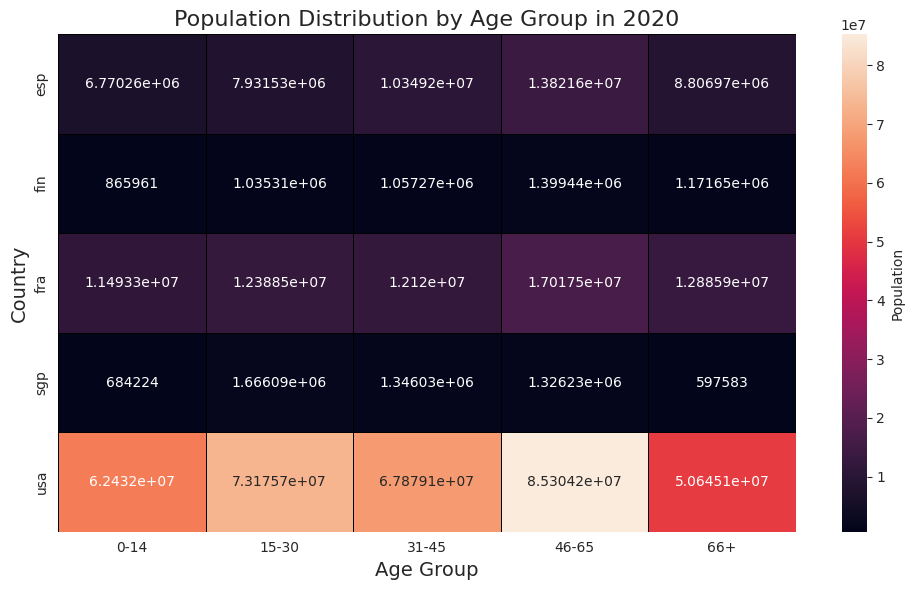

In [7]:
# Choose a specific year and countries of interest
specific_year = 2020

# Filter for the specific year and countries
filtered_data = filtered5[(filtered5['year'] == specific_year)]

# Group by country and age group, summing populations
population_distribution = filtered_data.groupby(['country', 'age_group'])['population'].sum().unstack(fill_value=0)

sns.set_style("whitegrid")
sns.color_palette("husl", 8)

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(population_distribution, annot=True, fmt='g', cbar_kws={'label': 'Population'},
            linewidths=0.5, linecolor='black')

# Add labels and title
plt.title(f'Population Distribution by Age Group in {specific_year}', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Country', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

Aside from sgp, the age group 46-65 was the most populous across the remaining 5 countries. The heatmap shows us this distribution by pairing lighter colors with higher populations and darker colors with lower populations. sgp is a small country; it has less people overall compared to the other countries. We know this because its row is all black. On the otherhand, it's easy to see that usa is the most populous country of the 5, because it has the most light colors in its row.

## 2. Create a pair of violin plots comparing the age distributions between two countries in 2020, separated by gender.
   - Create side-by-side violin plots using seaborn
   - Add clear labels and a title
   - Write a brief comparison of what the plots reveal

([<matplotlib.axis.XTick at 0x7740477ba5a0>,
 [Text(0, 0, '0'),
  Text(5, 0, '5'),
  Text(10, 0, '10'),
  Text(15, 0, '15'),
  Text(20, 0, '20'),
  Text(25, 0, '25'),
  Text(30, 0, '30'),
  Text(35, 0, '35'),
  Text(40, 0, '40'),
  Text(45, 0, '45'),
  Text(50, 0, '50'),
  Text(55, 0, '55'),
  Text(60, 0, '60'),
  Text(65, 0, '65'),
  Text(70, 0, '70'),
  Text(75, 0, '75'),
  Text(80, 0, '80'),
  Text(85, 0, '85'),
  Text(90, 0, '90'),
  Text(95, 0, '95'),
  Text(100, 0, '100')])

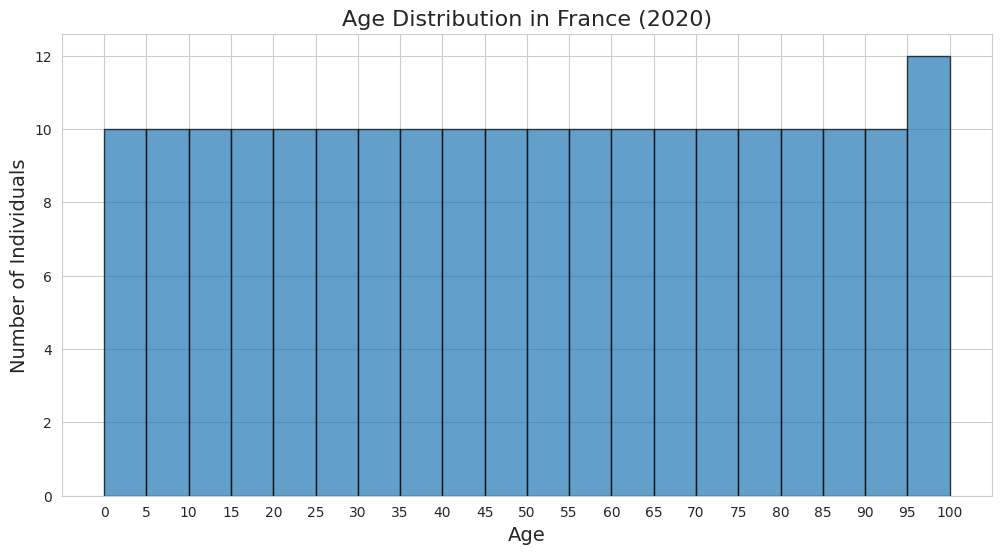

In [8]:
# Filter the data for the USA in the year 2020
fra_2020_data = combined_df[(combined_df['country'] == 'fra') & (combined_df['year'] == 2020)]

# Create a histogram for the age distribution
plt.figure(figsize=(12, 6))
plt.hist(fra_2020_data['age'], bins=range(0, 101, 5), edgecolor='black', alpha=0.7)

# Add labels and title
plt.title('Age Distribution in France (2020)', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Number of Individuals', fontsize=14)
plt.xticks(range(0, 101, 5))

([<matplotlib.axis.XTick at 0x774047691c10>,
 [Text(0, 0, '0'),
  Text(5, 0, '5'),
  Text(10, 0, '10'),
  Text(15, 0, '15'),
  Text(20, 0, '20'),
  Text(25, 0, '25'),
  Text(30, 0, '30'),
  Text(35, 0, '35'),
  Text(40, 0, '40'),
  Text(45, 0, '45'),
  Text(50, 0, '50'),
  Text(55, 0, '55'),
  Text(60, 0, '60'),
  Text(65, 0, '65'),
  Text(70, 0, '70'),
  Text(75, 0, '75'),
  Text(80, 0, '80'),
  Text(85, 0, '85'),
  Text(90, 0, '90'),
  Text(95, 0, '95'),
  Text(100, 0, '100')])

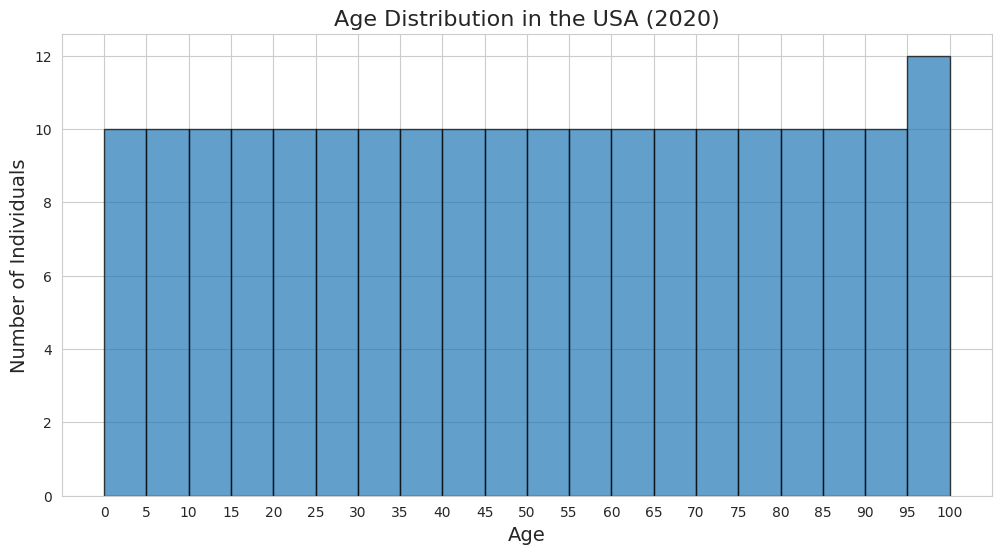

In [9]:
# Filter the data for the USA in the year 2020
usa_2020_data = combined_df[(combined_df['country'] == 'usa') & (combined_df['year'] == 2020)]

# Create a histogram for the age distribution
plt.figure(figsize=(12, 6))
plt.hist(usa_2020_data['age'], bins=range(0, 101, 5), edgecolor='black', alpha=0.7)

# Add labels and title
plt.title('Age Distribution in the USA (2020)', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Number of Individuals', fontsize=14)
plt.xticks(range(0, 101, 5))

In [10]:
filtered_data2 = filtered_data[(filtered_data['year'] == 2020) & (filtered_data['country'].isin(['fra', 'usa']))]
pivot_df2 = filtered_data2.groupby(['country', 'gender', 'age_group']).size().reset_index(name='count')

# Pivot the DataFrame to get separate columns for counts
pivot_df = pivot_df2.pivot_table(index='age_group', 
                                       columns=['country', 'gender'], 
                                       values='count', 
                                       fill_value=0)

# Flatten the column MultiIndex
pivot_df.columns = [f"{country}_g{gender}" for country, gender in pivot_df.columns]

pivot_df

,fra_g1,fra_g2,usa_g1,usa_g2
age_group,,,,
0-14,15.0,15.0,15.0,15.0
15-30,16.0,16.0,16.0,16.0
31-45,15.0,15.0,15.0,15.0
46-65,20.0,20.0,20.0,20.0
66+,35.0,35.0,35.0,35.0


        country  age  gender  year  population age_group
3233282     fra    0       1  2020      340466      0-14
3233433     fra    0       2  2020      325728      0-14
3233584     fra    1       1  2020      347877      0-14
3233735     fra    1       2  2020      331293      0-14
3233886     fra   10       1  2020      417327      0-14
...         ...  ...     ...   ...         ...       ...
3903571     usa   97       2  2020       59345       66+
3903722     usa   98       1  2020       14928       66+
3903873     usa   98       2  2020       41928       66+
3904024     usa   99       1  2020        9246       66+
3904175     usa   99       2  2020       27801       66+

[404 rows x 6 columns]


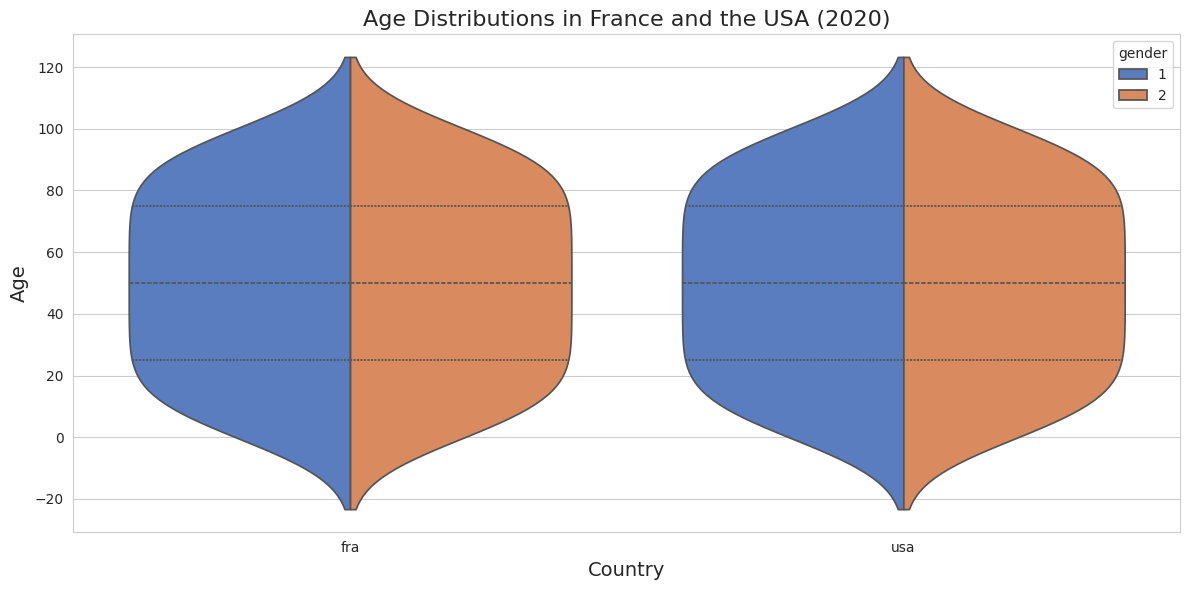

In [11]:
# Filter for the year 2020 and the selected countries 'fra' and 'usa'
filtered_data2 = filtered5[(filtered5['year'] == 2020) & (filtered5['country'].isin(['fra', 'usa']))]

# Check if the filtered_data contains the expected values
print(filtered_data2)

# Create side-by-side violin plots for the two countries, separated by gender
plt.figure(figsize=(12, 6))
sns.violinplot(data=filtered_data2, x='country', y='age', hue='gender', split=True, inner='quart', palette='muted')

# Add labels and title
plt.title('Age Distributions in France and the USA (2020)', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Age', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


The plots reveal that in 2020, fra and usa had the exact same age distribution across gender.

## 3. Create a pairplot comparing population metrics across four countries:
   - Select four countries of your choice
   - Include all variables in the dataset
   - Use the country as the hue parameter to distinguish between countries
   - Write a brief summary of any patterns or relationships revealed by the pairplot

In [ ]:
filtered4 = combined_df[combined_df['country'].isin(['usa', 'chn', 'esp' ,'fra'])]

plt.figure(figsize=(10, 6))

# Use 'country' as the hue parameter to distinguish the countries
sns.pairplot(filtered4, hue='country', vars=['age', 'gender', 'year', 'population'], palette='Set2')

# Set the title for the pairplot
plt.suptitle('Pairplot of Population Metrics for USA, China, Spain, and France', y=1.02, fontsize=16)

# Move the legend outside the plot toward the upper left
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


The pairplot reveals many trends. For example, in the plot of age (x-axis) and population (y-axis), we can see that china's population tends to decrease as age increases (there are less people that are 100 than there are that are 50) for most years. It also shows that gender is very evenly divided across year and age for the usa. China's population fluctuates greatly across year; we see this based off of the extreme variations as compared to the usa, which is relatively steady.